In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

In [35]:
# There is a variation that uses swaps, but this thing with kind of implicit circular shift needs less assignments
# There is also variation that uses binary search instead of linear
def insertion_sort(arr):
    for i in range(1, len(arr)):
        value_to_insert = arr[i]
        index_to_insert_after = i - 1
        
        while index_to_insert_after >=0 and value_to_insert < arr[index_to_insert_after]:
            arr[index_to_insert_after + 1] = arr[index_to_insert_after]
            index_to_insert_after -= 1
        
        arr[index_to_insert_after + 1] = value_to_insert
    
    return arr

In [18]:
# trivial sorts
print(insertion_sort([]))
print(insertion_sort([123]))

# ordered
print(insertion_sort([1, 2, 3]))
# reverse ordered
print(insertion_sort([3, 2, 1]))

# other permutations
print(insertion_sort([1, 3, 2]))
print(insertion_sort([2, 1, 3]))
print(insertion_sort([2, 3, 1]))
print(insertion_sort([3, 1, 2]))

[]
[123]
[1, 2, 3]
[1, 2, 3]
[1, 2, 3]
[1, 2, 3]
[1, 2, 3]
[1, 2, 3]


In [23]:
df = pd.DataFrame(columns=("array_size", "time"));

# be careful with size, because time complexity is quadratic
sizes = np.arange(1, 1000)
number_of_trials = 10

for array_size in sizes:
    arr = np.arange(array_size)
    rng = np.random.default_rng()
    rng.shuffle(arr)
    
    for i in range(number_of_trials):
        start = timer()
        sorted_arr = insertion_sort(arr)
        end = timer()
        delta = end - start
        
        new_row = {
            "array_size": array_size,
            "time": delta
        }
        
        df.loc[len(df)] = new_row

df

,array_size,time
0,1,0.000004
1,1,0.000004
2,1,0.000003
3,1,0.000004
4,1,0.000003
...,...,...
9985,999,0.000420
9986,999,0.000419
9987,999,0.000420
9988,999,0.000419


<AxesSubplot:xlabel='array_size', ylabel='time'>

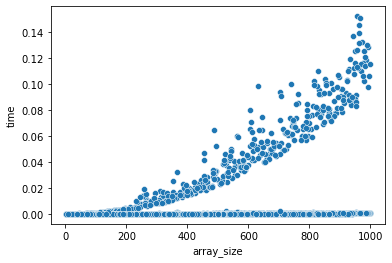

In [24]:
df_sample = df.sample(5000)
sns.scatterplot(data=df_sample, x="array_size", y="time")

Situation is similar to bubble sort - O(N^2) worst case and O(N) best case. And worst case is more than 3 times faster than bubble sort

<AxesSubplot:xlabel='array_size', ylabel='time'>

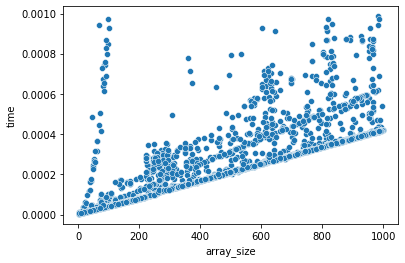

In [26]:
sns.scatterplot(data=df_sample[df_sample['time'] < 0.001], x="array_size", y="time")

Best cases with two defined lines and some noise

In [27]:
df_mean_times = df.groupby('array_size', as_index=False).agg(mean_time=pd.NamedAgg(column="time", aggfunc="mean"))
df_mean_times

,array_size,mean_time
0,1,0.000003
1,2,0.000006
2,3,0.000005
3,4,0.000006
4,5,0.000007
...,...,...
994,995,0.011819
995,996,0.010944
996,997,0.012324
997,998,0.011929


<AxesSubplot:xlabel='array_size', ylabel='mean_time'>

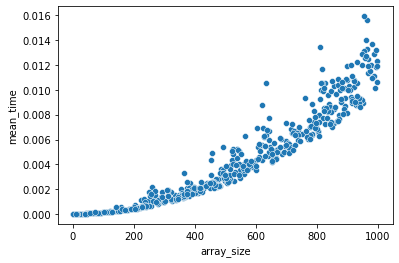

In [28]:
sns.scatterplot(data=df_mean_times.sample(500), x="array_size", y="mean_time")

O(N^2) average case

Now i will try to estimate mean time with linear regression

In [29]:
df_regression = pd.DataFrame({
    'array_size': df_mean_times['array_size'],
    'array_size^2': df_mean_times['array_size']**2,
    'mean_time': df_mean_times['mean_time']
})
df_regression

,array_size,array_size^2,mean_time
0,1,1,0.000003
1,2,4,0.000006
2,3,9,0.000005
3,4,16,0.000006
4,5,25,0.000007
...,...,...,...
994,995,990025,0.011819
995,996,992016,0.010944
996,997,994009,0.012324
997,998,996004,0.011929


In [30]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
X = df_regression[['array_size', 'array_size^2']]
y = df_regression['mean_time']

model.fit(X, y)

LinearRegression()

In [31]:
model.coef_

array([8.57347209e-07, 1.13903939e-08])

In [32]:
regression_array_size = np.arange(1, 1000)
df_regression_predicted = pd.DataFrame({
    'array_size': regression_array_size,
    'array_size^2': regression_array_size**2
})

df_regression_predicted['mean_time'] = model.predict(df_regression_predicted)

<AxesSubplot:xlabel='array_size', ylabel='mean_time'>

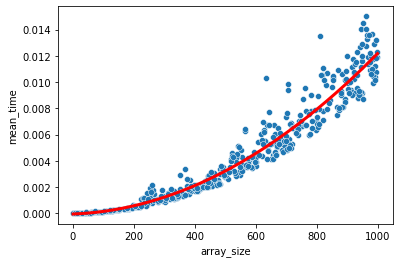

In [33]:
fig, ax = plt.subplots()

sns.scatterplot(ax=ax, data=df_mean_times.sample(500), x="array_size", y="mean_time")
sns.lineplot(ax=ax, data=df_regression_predicted, x="array_size", y="mean_time", color="red", linewidth = 3)